### FRE-6991-HW3
### cy2578
### Changling YI

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


### Step A: Construct the portfolio with the highest Sharpe Ratio (long only), ignoring the risk-free rate
Because the average daily consumption of PFE is the most advantageous relative to its volatility, the full-position PFE situation occurs. In order to disperse the weights more, I adopted a dispersion penalty strategy (using the Herfindahl index, i.e. $\sum_i w_i^2$) to penalize the dispersion of weights in the objective function. Doing so can drive the optimization results to a more diversified portfolio.

In [4]:
tickers = ["ED", "PFE", "IBM"]
start_date_in = "2024-01-01"
end_date_in = "2025-01-01"

# Download in-sample data (Adjusted Close prices)
df_in_sample = yf.download(tickers, start=start_date_in, end=end_date_in, progress=False)
df_in_sample = df_in_sample["Close"].dropna(how="all")

# Compute daily returns
returns_in_sample = df_in_sample.pct_change().dropna()

# Calculate the mean returns and covariance matrix
mu = returns_in_sample.mean()       # Average daily return for each asset
cov = returns_in_sample.cov()         # Covariance matrix of daily returns

# Set the diversification penalty coefficient lambda (adjust as needed)
lambda_penalty = 0.1  # For example, set to 0.1

# Define the objective function:
# Negative Sharpe ratio plus a penalty for concentration (using the sum of squared weights)
def objective_penalized(w, mu, cov, lambda_penalty):
    portfolio_return = np.dot(w, mu)
    portfolio_vol = np.sqrt(np.dot(w, np.dot(cov, w)))
    sharpe_ratio = portfolio_return / portfolio_vol
    penalty = lambda_penalty * np.sum(w**2)  # Higher sum of squared weights means a more concentrated portfolio
    return -sharpe_ratio + penalty

# Constraint: The sum of the weights must be 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
# Boundaries: Weights must be between 0 and 1 (long-only constraint)
bounds = [(0.0, 1.0)] * len(tickers)
# Initial guess: Equal weighting for all assets
initial_weights = np.array([1.0/len(tickers)] * len(tickers))

# Use SLSQP to solve the optimization problem
result = minimize(objective_penalized, initial_weights, args=(mu, cov, lambda_penalty),
                  method="SLSQP", bounds=bounds, constraints=constraints)
optimal_weights = result.x

# Compute the in-sample Sharpe ratio 
max_sharpe = np.dot(optimal_weights, mu) / np.sqrt(np.dot(optimal_weights, np.dot(cov, optimal_weights)))

print("Optimal Weights (with diversification penalty):")
print(pd.DataFrame(optimal_weights, index=tickers, columns=["Weight"]))
print("\nMaximum Sharpe Ratio (in-sample):", max_sharpe)
print("Final value of the objective function:", result.fun)

YF.download() has changed argument auto_adjust default to True
Optimal Weights (with diversification penalty):
       Weight
ED   0.268122
PFE  0.590987
IBM  0.140891

Maximum Sharpe Ratio (in-sample): 0.08558673260686728
Final value of the objective function: -0.04148621781622694


### Step B: Compute and Plot Out-of-Sample Portfolio Daily Returns

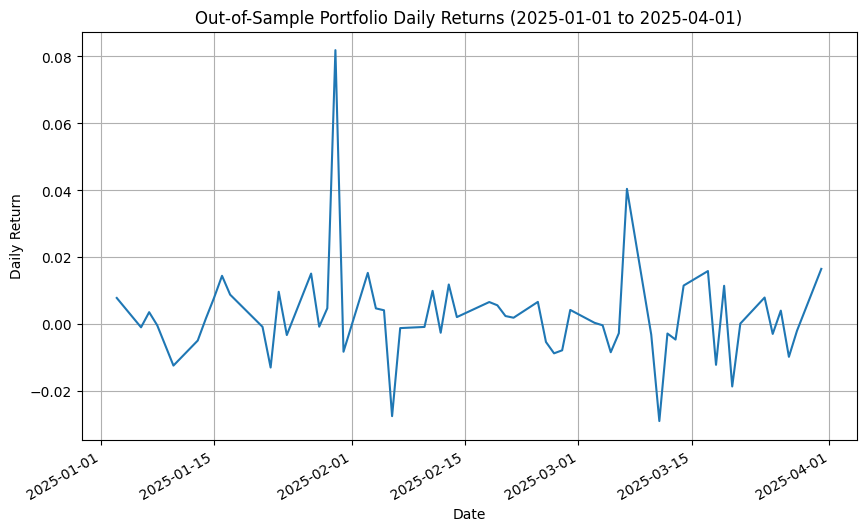

In [6]:
start_date_out = "2025-01-01"
end_date_out = "2025-04-01"

# Download out-of-sample data
df_out_sample = yf.download(tickers, start=start_date_out, end=end_date_out, progress=False)
df_out_sample = df_out_sample["Close"].dropna(how="all")

# Compute out-of-sample daily returns
returns_out_sample = df_out_sample.pct_change().dropna()

# Calculate portfolio daily returns using the optimal weights
portfolio_returns_out_sample = returns_out_sample.dot(optimal_weights)

# Plot the portfolio's daily returns
plt.figure(figsize=(10, 6))
portfolio_returns_out_sample.plot()
plt.title("Out-of-Sample Portfolio Daily Returns (2025-01-01 to 2025-04-01)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()

### Step C: Compare Expected Daily Return vs. Realized Daily Return

In [8]:
# Expected daily return (using in-sample data)
expected_daily_return = np.dot(optimal_weights, mu)

# Realized average daily return (from out-of-sample period)
realized_daily_return = portfolio_returns_out_sample.mean()

print("Expected Daily Return (in-sample):", expected_daily_return)
print("Realized Daily Return (out-of-sample):", realized_daily_return)
print("Difference (Realized - Expected):", realized_daily_return - expected_daily_return)

Expected Daily Return (in-sample): 0.0008724318374455373
Realized Daily Return (out-of-sample): 0.002428400980087158
Difference (Realized - Expected): 0.0015559691426416207


### Step D: Calculate Out-of-Sample Portfolio Volatility

In [10]:
realized_volatility = portfolio_returns_out_sample.std()
print("Realized Daily Volatility (out-of-sample):", realized_volatility)

Realized Daily Volatility (out-of-sample): 0.015092224149272752



### Step E: Compare Expected Volatility vs. Realized Volatility

In [12]:
expected_volatility = np.sqrt(np.dot(optimal_weights, np.dot(cov, optimal_weights)))
print("Expected Daily Volatility (in-sample):", expected_volatility)
print("Difference (Realized - Expected):", realized_volatility - expected_volatility)

Expected Daily Volatility (in-sample): 0.010193540644353741
Difference (Realized - Expected): 0.00489868350491901
